Date: 04/13/2025

Author: Nasheed Jafri

Purpose: Modeling risk of Alzheimer's as probabilities instead of raw classification

# Introduction

In this notebook, we shift from raw binary classification to a more nuanced and clinically relevant approach: **predicting the risk of developing Alzheimer's disease as calibrated probabilities**.

While binary predictions ("yes" or "no") are easy to interpret, they lack the depth needed in healthcare contexts, where understanding the **degree of risk** can significantly influence medical decisions. A probability-based prediction allows us to:
- Assist physicians in making informed, risk-aware decisions,
- Identify and prioritize high-risk individuals for early intervention,
- Communicate personalized risk more meaningfully to patients and caregivers.

To generate meaningful probabilities, we use our best-performing tuned models — an **AdaBoost classifier for the full dataset** and an **XGBoost classifier for a no-memory-complaints subset** — and calibrate their outputs. Calibration adjusts the model's raw confidence scores so they better reflect the true likelihood of a diagnosis.

We start with **isotonic regression**, a flexible, non-parametric calibration method suited for large datasets. Then, we compare it with **Platt scaling (sigmoid calibration)**, a parametric approach that fits a logistic curve, often more stable when data is limited.

By comparing both methods, we can determine which provides the most reliable probabilistic outputs for assessing Alzheimer’s risk.

Finally, we go a step further and map the resulting calibrated probabilities into **clinically interpretable risk categories** — such as **Low**, **Medium**, and **High risk**.

# Caliberated probabilities for the tuned model

In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import set_style

set_style("whitegrid")

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, root_mean_squared_error, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, roc_auc_score, RocCurveDisplay

In [31]:
df = pd.read_csv("/Users/nasheedjafri/Downloads/data/kaggle_train.csv")
df = df.drop(columns = ['DoctorInCharge' , 'PatientID' ])
df_train, df_test = train_test_split(df, random_state= 123 , shuffle= True,
                                     test_size=0.2, stratify=df['Diagnosis'])

In [33]:
## Seperating features into subcategories

all_features = ['Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI',
               'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality',
               'SleepQuality', 'FamilyHistoryAlzheimers', 'CardiovascularDisease',
               'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP',
               'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL',
               'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment',
               'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion',
               'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks',
               'Forgetfulness' , 'Diagnosis']
demo_features = ['Age', 'Gender', 'Ethnicity','EducationLevel','Diagnosis']
life_style_features = ['BMI','Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality','Diagnosis']
medic_hist_features = ['FamilyHistoryAlzheimers', 'CardiovascularDisease','Diabetes', 'Depression', 'HeadInjury', 'Hypertension','Diagnosis']
clinical_features = ['SystolicBP','DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL','CholesterolTriglycerides','Diagnosis']
cognitive_features = ['MMSE', 'FunctionalAssessment','MemoryComplaints', 'BehavioralProblems', 'ADL','Diagnosis']
symptoms_features = ['Confusion','Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks','Forgetfulness','Diagnosis']

no_cognitive = [item for item in all_features if item not in cognitive_features]
no_cognitive.append('Diagnosis')

subcategory_dict = {'all_features' : all_features,'demo':demo_features ,'lifestyle': life_style_features , 'medic' : medic_hist_features , 
                    'clinical':clinical_features , 'cognitive': cognitive_features , 'symptoms': symptoms_features , 'no_cognitive': no_cognitive}

## Tuned AdaBoost model for the entire dataset

In [35]:
# Best params from tuning
model_tuned_tree_params = {
    'criterion': 'entropy',
    'max_depth': 2,
    'min_samples_split': 19
}
model_tuned_ada_params = {
    'n_estimators': 130,
    'learning_rate': 0.26971280658002783,
    'algorithm': 'SAMME.R'
}

# Tuned AdaBoost model for the entire dataset
model_tuned_ = AdaBoostClassifier(
    **model_tuned_ada_params,
    estimator=DecisionTreeClassifier(**model_tuned_tree_params, random_state=123),
    random_state=123
)

In [48]:
# Isotonic calibration pipeline
calibrated_model_isotonic = CalibratedClassifierCV(estimator=model_tuned_, method='isotonic', cv=5)
calibrated_model_isotonic.fit(df_train[all_features[:-1]], df_train.Diagnosis)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/ana

CalibratedClassifierCV(cv=5,
                       estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                                                     max_depth=2,
                                                                                     min_samples_split=19,
                                                                                     random_state=123),
                                                    learning_rate=0.26971280658002783,
                                                    n_estimators=130,
                                                    random_state=123),
                       method='isotonic')

In [50]:
# Predict calibrated probabilities on the test set
calibrated_probs_isotonic = calibrated_model_isotonic.predict_proba(df_test[all_features[:-1]])[:, 1]  # Probability of class 1 (Alzheimer’s)

# Add to test dataframe for inspection
df_test['alzheimers_risk'] = calibrated_probs_isotonic
df_test[['Diagnosis', 'alzheimers_risk']].head()

,Diagnosis,alzheimers_risk
486,0,0.066837
397,1,0.711071
1339,1,0.884134
1311,0,0.035592
236,0,0.120600


In [56]:
# Sigmoid calibration pipeline (Platt scaling)
calibrated_model_sigmoid = CalibratedClassifierCV(estimator=model_tuned_, method='sigmoid', cv=5)
calibrated_model_sigmoid.fit(df_train[all_features[:-1]], df_train.Diagnosis)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/ana

CalibratedClassifierCV(cv=5,
                       estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                                                     max_depth=2,
                                                                                     min_samples_split=19,
                                                                                     random_state=123),
                                                    learning_rate=0.26971280658002783,
                                                    n_estimators=130,
                                                    random_state=123))

In [60]:
# Predict calibrated probabilities on the test set
calibrated_probs_sigmoid = calibrated_model_sigmoid.predict_proba(df_test[all_features[:-1]])[:, 1]  # Probability of class 1 (Alzheimer’s)

# Add to test dataframe for inspection
df_test['alzheimers_risk'] = calibrated_probs_sigmoid
df_test[['Diagnosis', 'alzheimers_risk']].head()

,Diagnosis,alzheimers_risk
486,0,0.189849
397,1,0.565853
1339,1,0.675354
1311,0,0.006624
236,0,0.206460


### Evalaute caliberation

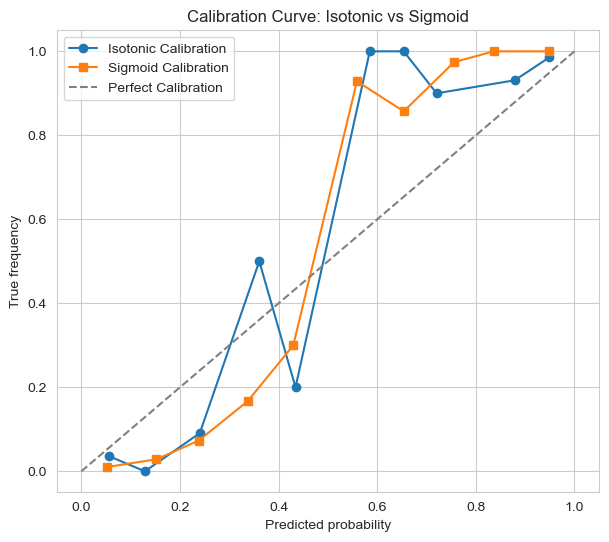

Brier Score (Isotonic): 0.0439
Brier Score (Sigmoid):  0.0618
ROC AUC Score (Isotonic): 0.9705
ROC AUC Score (Sigmoid):  0.9761


In [62]:
# Calibration curve values
true_iso, pred_iso = calibration_curve(df_test.Diagnosis, calibrated_probs_isotonic, n_bins=10)
true_sigmoid, pred_sigmoid = calibration_curve(df_test.Diagnosis, calibrated_probs_sigmoid, n_bins=10)

# Plot both curves
plt.figure(figsize=(7, 6))
plt.plot(pred_iso, true_iso, marker='o', label='Isotonic Calibration')
plt.plot(pred_sigmoid, true_sigmoid, marker='s', label='Sigmoid Calibration')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Predicted probability')
plt.ylabel('True frequency')
plt.title('Calibration Curve: Isotonic vs Sigmoid')
plt.legend()
plt.grid(True)
plt.show()

# Brier Scores (lower is better)
brier_iso = brier_score_loss(df_test.Diagnosis, calibrated_probs_isotonic)
brier_sigmoid = brier_score_loss(df_test.Diagnosis, calibrated_probs_sigmoid)

print(f"Brier Score (Isotonic): {brier_iso:.4f}")
print(f"Brier Score (Sigmoid):  {brier_sigmoid:.4f}")

# ROC AUC Scores (higher is better)
roc_auc_iso = roc_auc_score(df_test.Diagnosis, calibrated_probs_isotonic)
roc_auc_sigmoid = roc_auc_score(df_test.Diagnosis, calibrated_probs_sigmoid)

print(f"ROC AUC Score (Isotonic): {roc_auc_iso:.4f}")
print(f"ROC AUC Score (Sigmoid):  {roc_auc_sigmoid:.4f}")

### **Conclusion**

- Both models track the diagonal well above 0.5, meaning they’re generally well-calibrated for high-probability predictions.
- The isotonic model fluctuates more at lower probabilities — this is typical, as isotonic is non-parametric and can overfit small bins.
- The sigmoid model is smoother and slightly better around 0.4–0.6 range.
- Isotonic is better calibrated — its Brier Score is lower, meaning the probabilities it produces are closer to the true outcomes.
- Sigmoid is slightly better at ranking patients by risk — its ROC AUC is higher.

Which one to use, depends on our goal:

- If we care more about absolute risk estimation (e.g., "this patient has a 78% chance of Alzheimer's"), isotonic calbration is better.
- If our focus is on risk ranking or prioritization (e.g., sorting patients by who is most likely to have Alzheimer's), sigmoid calbiration is slightly better.

In clinical settings, Brier score and well-calibrated probabilities often matter more, so we might prefer isotonic for risk communication.

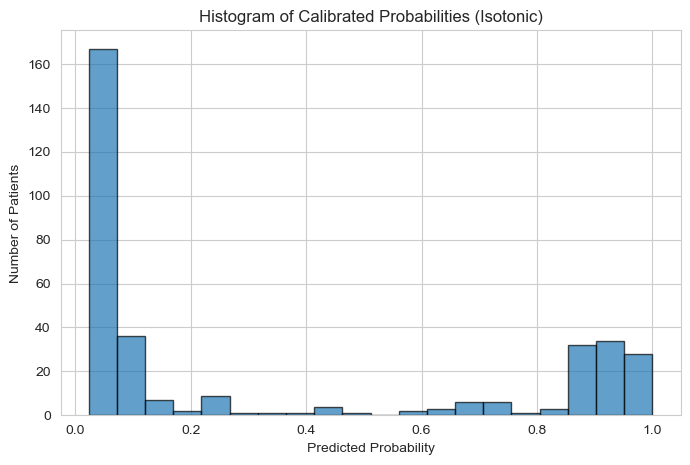

In [79]:
plt.figure(figsize=(8, 5))
plt.hist(calibrated_probs_isotonic, bins=20, edgecolor='k', alpha=0.7)
plt.title("Histogram of Calibrated Probabilities (Isotonic)")
plt.xlabel("Predicted Probability")
plt.ylabel("Number of Patients")
plt.grid(True)
plt.show()

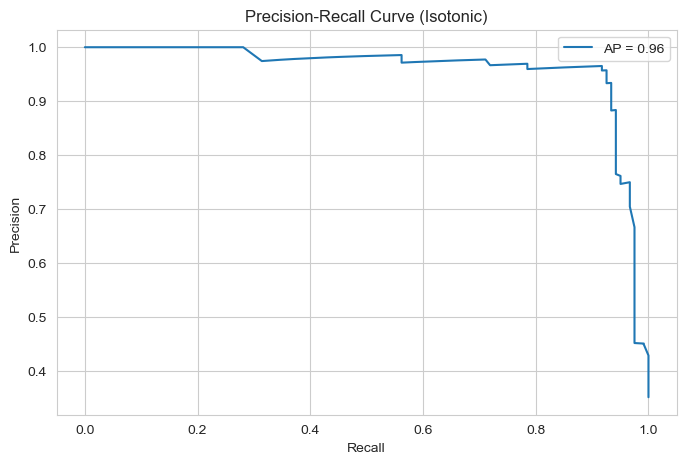

In [83]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(df_test.Diagnosis, calibrated_probs_isotonic)
ap_score = average_precision_score(df_test.Diagnosis, calibrated_probs_isotonic)

plt.figure(figsize=(8, 5))
plt.plot(recall, precision, label=f"AP = {ap_score:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Isotonic)")
plt.legend()
plt.grid(True)
plt.show()

## Tuned XGBoost model for the no-memory-complaints dataset

P.S. Need to discuss the tuned model for patients with no-memory-complaints

## Categorizing patients into Low/Medium/High risk groups

We now define risk buckets to categorize patients into low/mediun/high risk groups. Here’s a proposed thresholding scheme:

- Low Risk: risk probability < 0.33
- Medium Risk: 0.33 ≤ risk probability < 0.66
- High Risk: risk probability ≥ 0.66

We may adjust these cutoffs depending on how aggressive or conservative we want to be.

In [71]:
def assign_risk_group(prob):
    if prob < 0.33:
        return 'Low'
    elif prob < 0.66:
        return 'Medium'
    else:
        return 'High'

In [73]:
# Apply to the test set
df_test['risk_group'] = df_test['alzheimers_risk'].apply(assign_risk_group)
df_test[['Diagnosis', 'alzheimers_risk', 'risk_group']].head()

,Diagnosis,alzheimers_risk,risk_group
486,0,0.189849,Low
397,1,0.565853,Medium
1339,1,0.675354,High
1311,0,0.006624,Low
236,0,0.206460,Low


### **Distribution of Risk Groups**

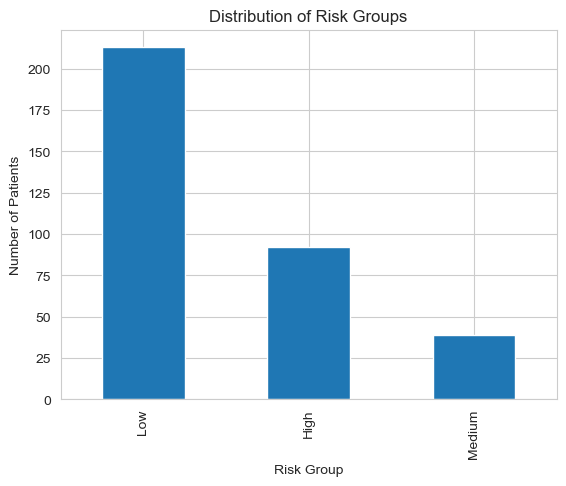

In [75]:
# How many patients fall into each category?
df_test['risk_group'].value_counts().plot(kind='bar', title='Distribution of Risk Groups')
plt.ylabel("Number of Patients")
plt.xlabel("Risk Group")
plt.grid(True)
plt.show()

Now that we've assigned risk groups (Low, Medium, High), let's see how actual diagnoses are distributed within each group.

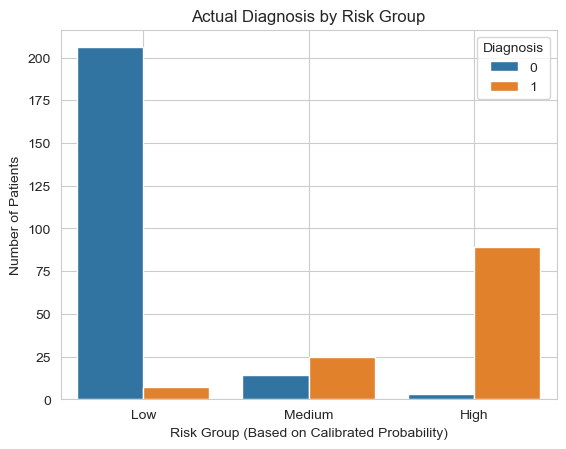

In [85]:
# Confusion matrix-like view of actual diagnosis vs. risk group
sns.countplot(x='risk_group', hue='Diagnosis', data=df_test)
plt.title("Actual Diagnosis by Risk Group")
plt.ylabel("Number of Patients")
plt.xlabel("Risk Group (Based on Calibrated Probability)")
plt.grid(True)
plt.show()